# **Implicit Runge Kutta method**

In [10]:
import numpy as np
import matplotlib.pyplot as plt

### *Implementation*

With the Butcher Tableau

$\begin{array}{c|cc}
c_1 & a_{11} & a_{12} \\
\\
c_2 & a_{21} & a_{22} \\
\\
\hline
  & b_1 & b_2
\end{array} \quad = \quad
\begin{array}{c|cc}
\frac{1}{2} - \frac{\sqrt{3}}{6}  & \frac{1}{4} & \frac{1}{4}-\frac{\sqrt{3}}{6} \\
\\
\frac{1}{2} + \frac{\sqrt{3}}{6}  & \frac{1}{4} + \frac{\sqrt{3}}{6} & \frac{1}{4} \\
\\
\hline
  & \frac{1}{2} & \frac{1}{2}
\end{array}$

we yield the stages of $k$ function:

$k_1 = f(t_n+c_1 h, x_n+h (a_{11} k_1 + a_{12} k_2))$

$k_2 = f(t_n+c_2 h, x_n+h (a_{21} k_1 + a_{22} k_2))$

<br>

We formulate a system of nonlinear equations:

$F_1(k_1,k_2) = k_1 - f(t_n+c_1 h, x_n+h (a_{11} k_1 + a_{12} k_2))$

$F_2(k_1,k_2) = k_2 - f(t_n+c_2 h, x_n+h (a_{21} k_1 + a_{22} k_2))$

<br>

We now find the Jacobian matrix of $F(k_1,k_2)$ for Newton's root finding method

$k_{n+1} = k_n - \frac{F(k_n)}{J(k_n)}, \quad $ where $k_n=(k_1,k_2)$ at each iteration 

The Jacobian matrix:

$J(k) =
\begin{bmatrix}
\frac{\partial F_1}{\partial k_1} & \frac{\partial F_1}{\partial k_2} \\
\frac{\partial F_2}{\partial k_1} & \frac{\partial F_2}{\partial k_2} \\
\end{bmatrix} = 
\begin{bmatrix}
I-ha_{11}f_x(t_n+c_1 h, x_n+h (a_{11} k_1 + a_{12} k_2)) & -ha_{12}f_x(t_n+c_1 h, x_n+h (a_{11} k_1 + a_{12} k_2)) \\
-ha_{21}f_x(t_n+c_2 h, x_n+h (a_{21} k_1 + a_{22} k_2)) & I-ha_{22}f_x(t_n+c_2 h, x_n+h (a_{21} k_1 + a_{22} k_2)) \\
\end{bmatrix}$

<br>

We rewrite the formular of Newton's method:

$J(k_n) \cdot (k_{n+1}-k_n) = J(k_n) \cdot \Delta k_{n+1} = -F(k_n), \quad$ where $\Delta k_{n+1}$ is the deviation of the new guessed k values from the previous ones

Hence we can use *np.linalg.solve()* to solve the system of nonlinear equations

In [11]:
def implicit_runge_kutta(ode_f, df_over_dx, x_n, t_n, h, tol, maxit):

    ########## Butcher Tableau ##########
    c1 = 1/2 - np.sqrt(3)/6
    c2 = 1/2 + np.sqrt(3)/6

    a11, a12 = 1/4, 1/4 - np.sqrt(3)/6  
    a21, a22 = 1/4 + np.sqrt(3)/6, 1/4

    b1, b2 = 1/2, 1/2


    ########## Newton's method ##########
    m = np.size(x_n)   # Number of ODEs in the system

    # Initial guess for k values
    k = np.zeros((2, m))
    for _ in range(maxit):
        # System of nonlinear equations
        F = np.zeros((2, m))
        F[0] = k[0] - ode_f(t_n + c1*h, x_n + h*(a11*k[0] + a12*k[1]))
        F[1] = k[1] - ode_f(t_n + c2*h, x_n + h*(a21*k[0] + a22*k[1]))

        # Jacobian matrix
        J = np.zeros((2*m, 2*m))
        I = np.eye(m)
        J[:m, :m] = I - h * a11 * df_over_dx(t_n + c1*h, x_n + h*(a11*k[0] + a12*k[1]))
        J[:m, m:] = - h * a12 * df_over_dx(t_n + c1*h, x_n + h*(a11*k[0] + a12*k[1]))
        J[m:, :m] = - h * a21 * df_over_dx(t_n + c2*h, x_n + h*(a21*k[0] + a22*k[1]))
        J[m:, m:] = I - h * a22 * df_over_dx(t_n + c2*h, x_n + h*(a21*k[0] + a22*k[1]))

        delta_k = np.linalg.solve(J, -F.flatten())   # Deviation, shape of 1D array since F has been flattened
        delta_k = delta_k.reshape(2, m)   # Reshape k into 2xm Matrix
        k += delta_k   # Adjust k values
        if np.linalg.norm(delta_k, np.inf) < tol:   # Condition to terminate the Newton iteration
            break
    
    
    return t_n + h, x_n + h * (b1*k[0] + b2*k[1])


Implement the other two explicit methods to compare the rate of convergence

In [12]:
def explicit_euler(ode_f, x0, t0, tend, h):
    
    # Initial condition as first elements of the lists
    t_values = [t0]
    x_values = [x0]

    # Euler iteration
    while t_values[-1] + h < tend:
        t_n = t_values[-1]
        x_n = x_values[-1]

        # Update y and t lists
        x_values.append(x_n + h*ode_f(t_n , x_n))
        t_values.append(t_n + h)


    return t_values, x_values

In [13]:
def explicit_rk4(ode_f, x0, t0, tend, h):
    
    # Initial condition as first elements of the lists
    t_values = [t0]
    x_values = [x0]

    # Runge-Kutta 4 iteration
    while t_values[-1] + h < tend:
        t_n = t_values[-1] 
        x_n = x_values[-1]
        
        ########## Butcher Tableau ##########
        # Compute k values
        k1 = ode_f(t_n , x_n)
        k2 = ode_f(t_n + h/2 , x_n + h/2*k1)
        k3 = ode_f(t_n + h/2 , x_n + h/2*k2)
        k4 = ode_f(t_n + h , x_n + h*k3)

        # Update x and t lists
        x_values.append(x_n + h * (1/6*k1 + 1/3*k2 + 1/3*k3 + 1/6*k4))
        t_values.append(t_n + h)


    return t_values, x_values

### *Test run and Rate of Convergence*

Given the ODE with the initial value

$\dot{x}(t) = t^2x(t)^2, \quad x(0) = -3$

which has the analytical result

$x(t) = \frac{-3}{1+t^3}$

In [14]:
# Ordinary differential equation
def ode_f(t, x):   
    return t**2 * x**2

# Derivative of the ODE in respect to x
def df_over_dx(t, x):   
    return 2 * t**2 * x

# Analytical result
def analytical_result(t):   
    return -3 / (1 + t**3)

Test run all methods and plot their rates of convergence

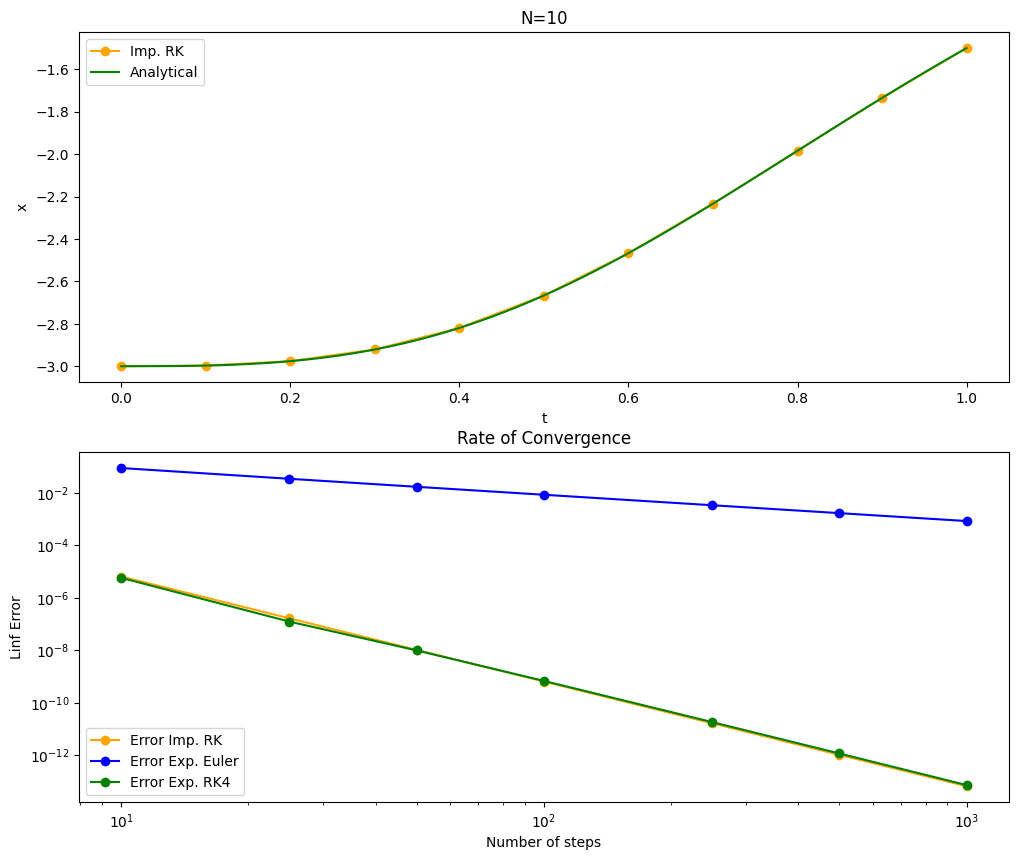

In [15]:
# Initial value and timespan
x0 = -3
t0, tend = 0, 1

n_list = [10, 25, 50, 100, 250, 500, 1000]   # Number of steps

tol = 10**(-10)   # Tolerance for Newton's method iteration
maxit = 1000   # Maximun number of Newton's method iteration

# Initialize lists to store error
err_irk = []
err_euler = []
err_erk4 = []


for n in n_list:
    h = (tend - t0) / n

    # Implicit Runge-Kutta
    # Store the values
    x_values_irk = [x0]
    t_values_irk = [t0]
    for _ in range(n):
        result_irk = implicit_runge_kutta(ode_f, df_over_dx, x_values_irk[-1], t_values_irk[-1], h, tol, maxit)
        t_values_irk.append(result_irk[0])
        x_values_irk.append(result_irk[1].item())   # Get the only item of the array

    # Store the values for the first plot with the wished choice of n
    if n==10:
        N = n
        t_firstplot = t_values_irk
        x_firstplot = np.array(x_values_irk)

    x_values_irk = np.array(x_values_irk)   # Convert to numpy array
    err_irk.append(np.max(np.abs(x_values_irk - np.vectorize(analytical_result)(t_values_irk))))

    # Explicit Euler
    result_euler = explicit_euler(ode_f, x0, t0, tend, h)
    err_euler.append(np.max(np.abs(result_euler[1] - np.vectorize(analytical_result)(result_euler[0]))))

    # Explicit Runge-Kutta 4
    result_erk4 = explicit_rk4(ode_f, x0, t0, tend, h)
    err_erk4.append(np.max(np.abs(result_erk4[1] - np.vectorize(analytical_result)(result_erk4[0]))))

# Plot the results
plt.figure(figsize=(12, 10))
plt.subplot(2,1,1)
plt.plot(t_firstplot, x_firstplot, marker='o', label='Imp. RK', color='orange')
plt.plot(t_values_irk, np.vectorize(analytical_result)(t_values_irk), label='Analytical', color='green')
plt.xlabel('t')
plt.ylabel('x')
plt.title(f'N={N}')
plt.legend()

plt.subplot(2,1,2)
plt.loglog(n_list, err_irk, marker='o', label='Error Imp. RK', color='orange')
plt.loglog(n_list, err_euler, marker='o', label='Error Exp. Euler', color='blue')
plt.loglog(n_list, err_erk4, marker='o', label='Error Exp. RK4', color='green')
plt.xlabel('Number of steps')
plt.ylabel('Linf Error')
plt.title('Rate of Convergence')
plt.legend()

plt.show()

Conclusion: The implicit Runge Kutta method with the given Butcher Tableau has the same rate of convergence with the explicit Runge Kutta 4 method (rate of convergence: 4). 

### *Lotka Voltera equations*

The interaction between prey and predator populations can be depicted by the *Lotka Volterra equations*. Given the system

$\dot{x}_1 = c_1 \cdot (1 - d_1 \cdot x_2)x_1,$
<br>
$\dot{x}_2 = c_2 \cdot (d_2 \cdot x_1 - 1)x_2$

Execute the implicit method for the system in the span of $t \in [0, 30]$ with the initial values

$x_1(0) = 10,$
<br>
$x_2(0) = 5$

In [16]:
# System of ODES
def lotka_volterra_equation(t, x):
    x1, x2 = x
    c1, c2, d1, d2 = 1, 1/2, 1/10, 1/15

    x1dot = c1 * (1 - d1 * x2) * x1
    x2dot = c2 * (d2 * x1 - 1) * x2
    return np.array([x1dot, x2dot])

# First derivative for Jacobian matrix
def derivative(t, x):
    x1, x2 = x
    c1, c2, d1, d2 = 1, 1/2, 1/10, 1/15

    dx1dot_over_dx1 = c1 * (1 - d1 * x2)
    dx1dot_over_dx2 = - c1 * d1 * x1
    dx2dot_over_dx1 = c2 * d2 * x2
    dx2dot_over_dx2 = c2 * (d2 * x1 - 1)
    return np.array([[dx1dot_over_dx1, dx1dot_over_dx2],
                    [dx2dot_over_dx1, dx2dot_over_dx2]])

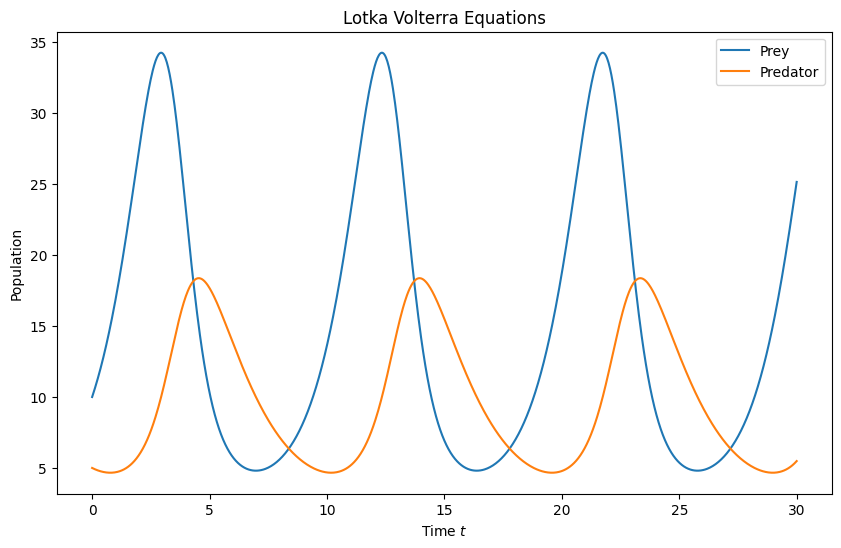

In [17]:
# Initial value and timespan
x0 = np.array([10, 5])
t0, tend = 0, 30

n = 1000   # Number of steps
h = (tend - t0) / n   # Step size
tol = 10**(-10)   # Tolerance for Newton's method iteration
maxit = 1000   # Maximun number of Newton's method iteration

# Store the values
t_values = [t0]
x_values = [x0]

for i in range (n):
    result = implicit_runge_kutta(lotka_volterra_equation, derivative, x_values[-1], t_values[-1], h, tol, maxit)
    t_values.append(result[0])
    x_values.append(result[1])

x_values = np.array(x_values)   # Convert to numpy array


# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_values, x_values[:, 0], label="Prey")
plt.plot(t_values, x_values[:, 1], label="Predator")
plt.xlabel("Time $t$")
plt.ylabel("Population")
plt.legend()
plt.title("Lotka Volterra Equations")
plt.show()

### *Phase space and Phase trajectory of the population relation*

C:\Users\Anh Tung Le\AppData\Local\Temp\ipykernel_96820\925581056.py:11: RuntimeWarning: invalid value encountered in divide
  dx_normalized = dx/magnitude


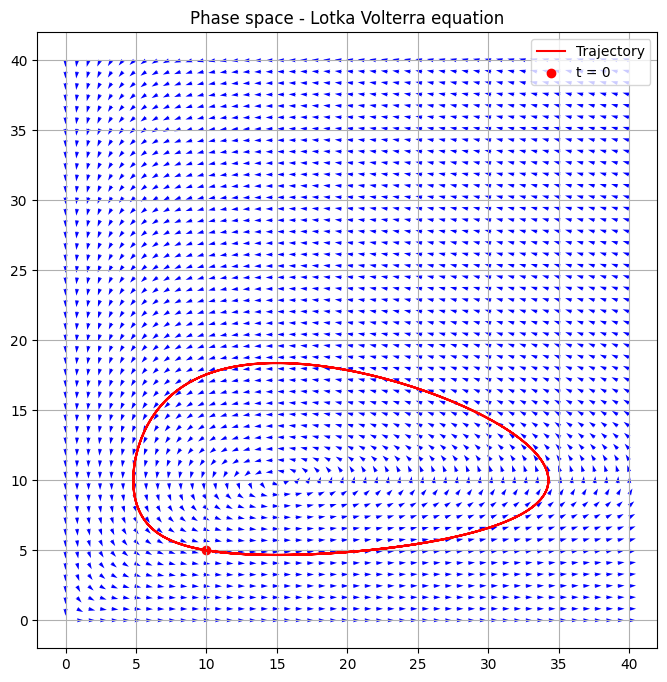

In [18]:
# Define the grid
x1 = np.linspace(0, 40, 50)
x2 = np.linspace(0, 40, 50)
X1, X2 = np.meshgrid(x1, x2)

# Compute vector field
dx = lotka_volterra_equation(0, [X1, X2])

# Normalize the vectors (all arrows have the same length)
magnitude = np.sqrt(dx[0]**2 + dx[1]**2)
dx_normalized = dx/magnitude

plt.figure(figsize=(8, 8))
# PLot the phase space
plt.quiver(X1,X2, dx_normalized[0], dx_normalized[1], color='blue')

# Plot the trajectory 
plt.plot(x_values[:, 0], x_values[:, 1], color='red', label='Trajectory')
plt.scatter(x_values[0, 0], x_values[0, 1], color='red', label='t = 0')
plt.title('Phase space - Lotka Volterra equation')
plt.legend()
plt.grid()
plt.show()
